<a href="https://colab.research.google.com/github/saba-ramezani/Fine_Tuning_T5_for_Samsum_Dialogue_Summarization/blob/main/Fine_Tuning_T5_for_Samsum_Dialogue_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning T5 for Samsum Dialogue Summarization

In [ ]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install -U sentencepiece
# !pip install -U urllib3
# !pip install py7zr

In [11]:
import warnings
warnings.filterwarnings('ignore')

## Benchmarking Bart & T5 on a sample from CNN-Dailymail dataset

In [12]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", '3.0.0', split="train[:10]")

In [13]:
print(dataset[0]['article'])
print("\nSummary:\n")
print(dataset[0]['highlights'])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [14]:
from transformers import pipeline
import torch

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
summary = {}
pipe = pipeline('summarization', model = 'ubikpt/t5-small-finetuned-cnn', device=device)
output = pipe(dataset[0]['article'])
summary['t5-small'] = output[0]['summary_text']

pipe = pipeline('summarization', model = 'facebook/bart-large-cnn', device=device)
output = pipe(dataset[0]['article'])
summary['bart-large'] = output[0]['summary_text']

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Device set to use cpu


In [15]:
for model in summary:
    print()
    print(model)
    print(summary[model])


t5-small
Harry Potter star Daniel Radcliffe says he has no plans to fritter his cash away . The actor has filmed a TV movie about author Rudyard Kipling

bart-large
Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund. Details of how he'll mark his landmark birthday are under wraps.


In [16]:
# We can see that bart proviced a much more concise summary compared to t5,
# and thats probably because the number of params in each model! T5 has only 60 million params while Bart has 406 million params.

## 1. Load the Samsum Dialogue Dataset

In [26]:
samsum = load_dataset("knkarthick/samsum")
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

In [30]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [36]:
from datasets import concatenate_datasets, Dataset, DatasetDict
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Concatenate train, validation, and test
full_dataset = concatenate_datasets([
    samsum['train'],
    samsum['validation'],
    samsum['test']
])

# 2. Convert to DataFrame
df = pd.DataFrame(full_dataset)

# 3. Show number of None values
print("Number of None in each column BEFORE cleaning:")
print(df.isnull().sum())

# 4. Drop rows with None in dialogue or summary
df_clean = df.dropna(subset=['dialogue', 'summary'])

print("\nNumber of None AFTER cleaning:")
print(df_clean.isnull().sum())

# 5. Re-split into train/val/test (keep original ratios ~80/10/10)
train_df, temp_df = train_test_split(df_clean, test_size=0.1, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 6. Convert back to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset   = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset  = Dataset.from_pandas(test_df, preserve_index=False)

# 7. Wrap into DatasetDict
samsum_clean = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})


Number of None in each column BEFORE cleaning:
id          0
dialogue    1
summary     0
dtype: int64

Number of None AFTER cleaning:
id          0
dialogue    0
summary     0
dtype: int64


In [37]:
samsum_clean

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

In [38]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum_clean['train']]
summary_len = [len(x['summary'].split()) for x in samsum_clean['train']]

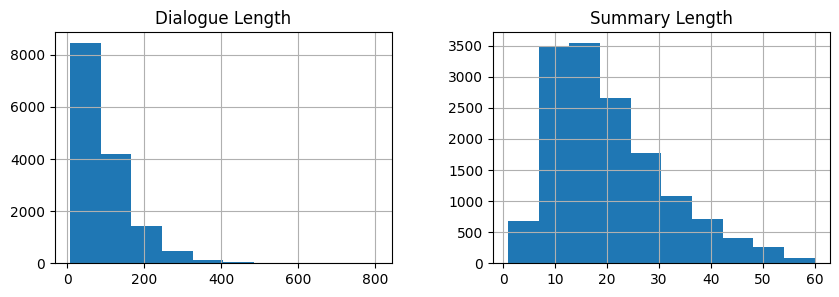

In [40]:
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(10,3));

## 2. Tokenization

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_ckpt = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [44]:
samsum_clean['train'][1]

{'id': '13829903',
 'dialogue': 'Agnes: Does Ann have a birthday today?\nMona: No, next Wednesday\nAgnes: I had to make a mistake.\nAgnes: Thanks!',
 'summary': 'Ann has a birthday next Wednesday. '}

In [45]:
tokenizer(samsum_clean['train'][0]['dialogue'], text_target=samsum_clean['train'][0]['summary'], return_tensors='pt')

{'input_ids': tensor([[  276, 22648,    10,  2114,    25,   608,    96, 24151, 20364,    58,
          8208,   509,    10,   955,  2091,    58,   276, 22648,    10,  4273,
          8208,   509,    10,   417,     6,    62,   608,    34,    16,  2061,
           270,   480, 15809,    10,    27,    31,   162,   470,   608,    34,
             6, 12855,  6308,    15,    10,    27,   410,     6,    34,    31,
             7,     3,     9,   182,   207,   484,   276, 22648,    10,  8611,
           845,    78,  6308,    15,    10,   608,    34,     6,    25,   751,
            31,    17,  9867,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]]), 'labels': tensor([[  276, 22648,     6,  8208,   509,    11,  6308,    15,   608,   955,
          2091,    31,   

In [46]:
def tokenize(batch):
    encoding = tokenizer(batch['dialogue'], text_target=batch['summary'], max_length=200, truncation=True, padding=True, return_tensors='pt')

    return encoding

In [ ]:
samsum_pt = samsum_clean.map(tokenize, batched=True, batch_size=None)

In [48]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
})